In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
#create the initial dataframe using CSV file

df = pd.read_csv("Vendors.csv", delimiter=',')
df['State Code'] = df['City/State'].str[-2:]
shuffled = df.sample(frac=1)
shuffled.head()

,Vendor Number,Vendor Name,Street Address,City/State,Zip Code,Country,Phone Number,Fax Number,E-mail Address,Status,State Code
712,200713,Integrated Technology Corp,1228 North Stadem Drive,"Tempe, AZ",85281,United States,480-968-3459,480-968-3099,jay@inttechcorp.com,Active,AZ
2507,202512,Santa Clara Systems,2060 North Loop Road,"Alameda, CA",94502,United States,510-995-3390,510-995-3398,sales#santaclarasystems.com,Active,CA
3337,203342,"Suez WTS Analytical Instruments, Inc.",6060 Spine Road,"Boulder, CO",80301,United States,13034442009,13034442009,sievers.customercare.wts@suez.com,Active,CO
3225,203230,"SHENZHEN GOLIGHT TECH CO., LTD","7 floor Caihuang building, No.6 Qingning Rd","Shenzhen, CN",518109,China,86-755-8349-3996,86-755-8349-0000,tang@go2light.com,Active,CN
1980,201983,Central Industrial Corporation Berhad,"Lot 77 & 78, Persiaran 11, Kawasan Perusahaan ...","Sungai Petani, Kedah",8000,Malaysia,604-4227888,604-4256888,kennethyao@cicm.com.my,Active,ah


In [4]:
#create a dataframe only contains key attributes

data1 = df.groupby('State Code').count()[['Vendor Name']]
data1.reset_index(inplace=True)
data1.rename(columns = { 'State Code' : 'STATE', 'Vendor Name' : 'Vendor Count'}, inplace=True)
data1

,STATE,Vendor Count
0,2,2
1,7,1
2,*,2
3,",",1
4,.C,1
...,...,...
243,xx,2
244,"y,",1
245,ya,3
246,yo,12


In [5]:
#create a geodataframe using sahpe file

shp_gdf = gpd.read_file('s_22mr22.shp')
shp_gdf.head()

,STATE,NAME,FIPS,LON,LAT,geometry
0,AK,Alaska,02,-152.24098,64.24019,"MULTIPOLYGON (((-179.10754 51.30120, -179.1054..."
1,AL,Alabama,01,-86.82676,32.79354,"MULTIPOLYGON (((-88.11011 30.25891, -88.10638 ..."
2,AR,Arkansas,05,-92.43920,34.89977,"POLYGON ((-91.62986 36.49921, -91.62849 36.499..."
3,AS,American Samoa,60,-170.37215,-14.26486,"MULTIPOLYGON (((-170.77310 -14.36245, -170.773..."
4,AZ,Arizona,04,-111.66457,34.29323,"POLYGON ((-110.49090 37.00361, -110.48750 37.0..."


In [6]:
#merge two dataframes, this is the geodataframe that's ready to use

mergeo = shp_gdf.merge(data1, on='STATE', how='left')
mergeo.dropna(inplace=True)
mergeo.head()

,STATE,NAME,FIPS,LON,LAT,geometry,Vendor Count
1,AL,Alabama,01,-86.82676,32.79354,"MULTIPOLYGON (((-88.11011 30.25891, -88.10638 ...",1.0
2,AR,Arkansas,05,-92.43920,34.89977,"POLYGON ((-91.62986 36.49921, -91.62849 36.499...",3.0
3,AS,American Samoa,60,-170.37215,-14.26486,"MULTIPOLYGON (((-170.77310 -14.36245, -170.773...",1.0
4,AZ,Arizona,04,-111.66457,34.29323,"POLYGON ((-110.49090 37.00361, -110.48750 37.0...",340.0
5,CA,California,06,-119.60818,37.24537,"MULTIPOLYGON (((-118.42620 32.79973, -118.4263...",640.0


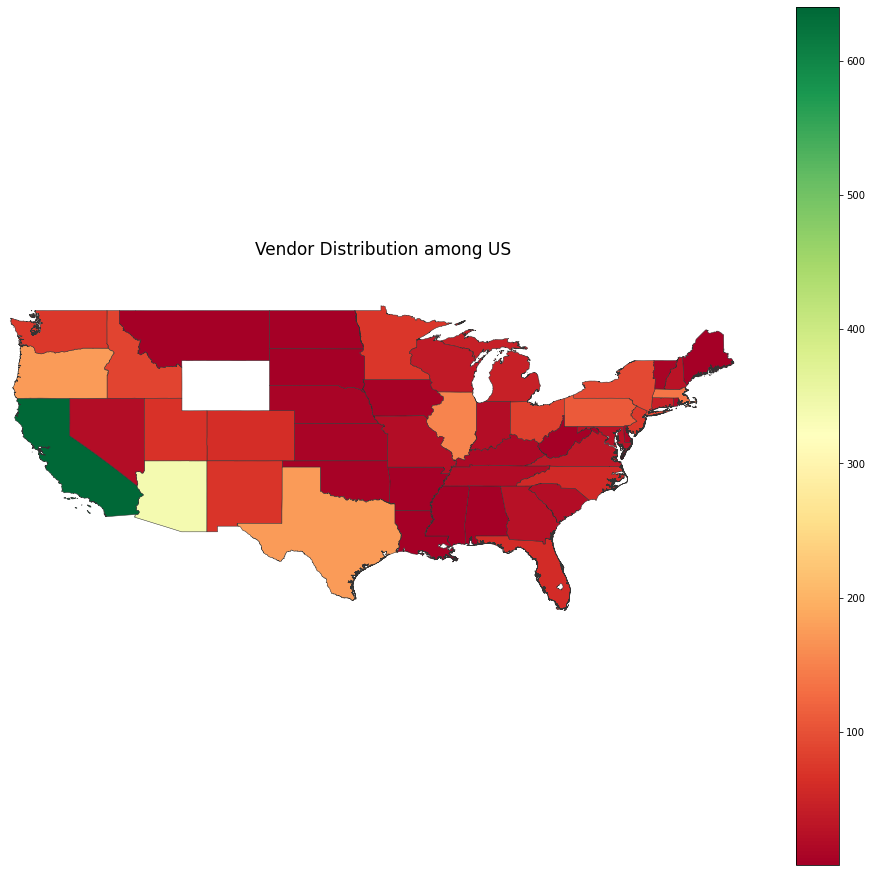

In [7]:
#Plot vendor distribution in the U.S.

xlim = (-125, -65)
ylim = (25, 53)

fig, ax = plt.subplots(figsize=(12, 12), constrained_layout=True)
ax.axis('off')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title('Vendor Distribution among US',
             fontdict={'fontsize': '17', 'fontweight' : '3'})
fig = mergeo.plot(column='Vendor Count', cmap='RdYlGn', linewidth=0.5, ax=ax, edgecolor='0.2',legend=True)

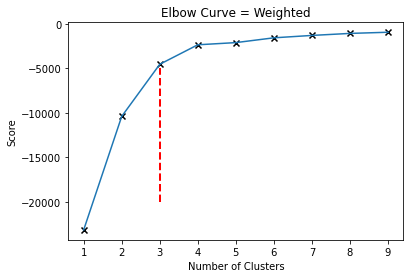

In [8]:
#decide the optimal qty of warehouse locations based on curreent vendor distribution, Elbow method 

K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]

lon_lat = mergeo[mergeo.columns[3:5]]
lot_size = mergeo[mergeo.columns[6]]
sample_weight = lot_size
score = [kmeans[i].fit(lon_lat, sample_weight = lot_size).score(lon_lat) for i in range(len(kmeans))]

plt.plot(K_clusters, score)
plt.scatter(K_clusters, score,marker='x', color='black')
plt.plot([3, 3], [-20000,-5000],color='red', linestyle='dashed',linewidth=2)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve = Weighted')
plt.show()

In [17]:
#calculate the optimal coordiantes for new warehouses

kmeans = KMeans(n_clusters = 3, max_iter=300, init ='k-means++')

lon_lat = mergeo[mergeo.columns[3:5]]
lot_size = mergeo[mergeo.columns[6]]
weighted_kmeans_clusters = kmeans.fit(lon_lat, sample_weight = lot_size) # Compute k-means clustering

mergeo['cluster_label'] = kmeans.predict(lon_lat, sample_weight = lot_size)

centers = kmeans.cluster_centers_   # Coordinates of cluster centers

Text(0.5, 1.0, 'Optimal Warehouse Locations')

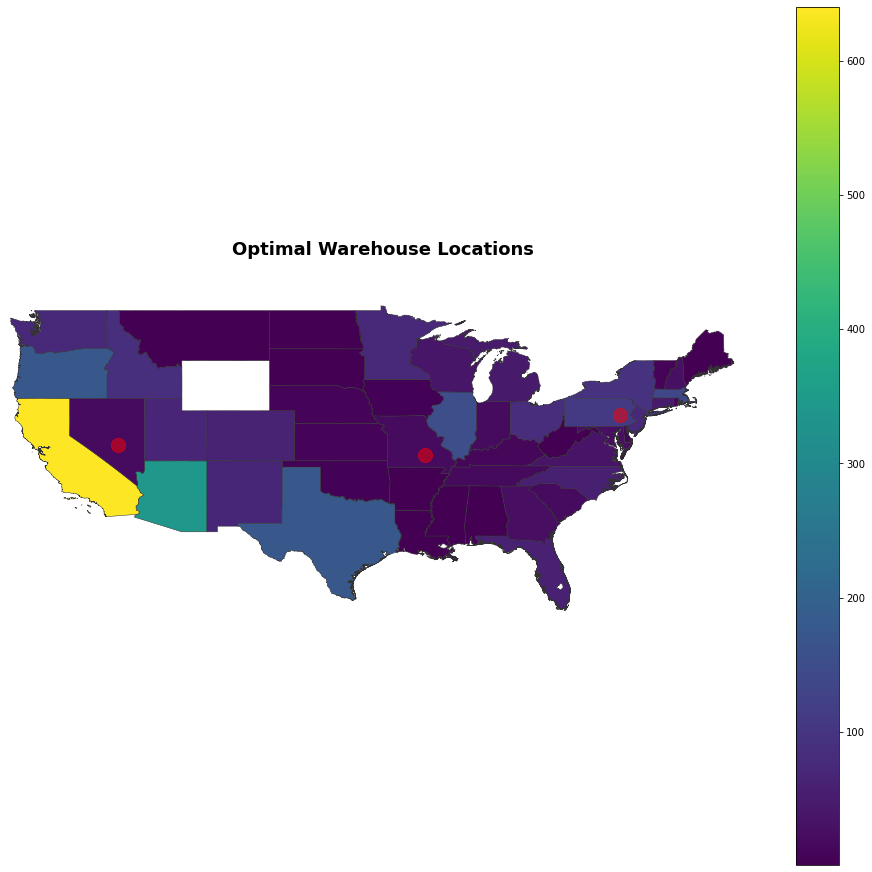

In [18]:
#plot optimal warehouse locations

xlim = (-125, -65)
ylim = (25, 53)

fig, ax = plt.subplots(figsize=(12, 12), constrained_layout=True)
ax.axis('off')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
fig = mergeo.plot(column='Vendor Count', cmap='viridis', linewidth=0.5, ax=ax, edgecolor='0.2',legend=True)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5)  
plt.title('Optimal Warehouse Locations',fontsize=18, fontweight='bold')

In [19]:
centers

array([[ -76.09989319,   40.64005914],
       [-116.19020364,   38.29348388],
       [ -91.65637638,   37.47323146]])

In [20]:
#physical address of optimal warehouse locations

geolocator = Nominatim(user_agent="OP_loc")

location1 = geolocator.reverse("37.79268459, -96.72479319")
location2 = geolocator.reverse("39.67768526, -77.70397788")
location3 = geolocator.reverse("38.45303322, -117.14737895")


locations = [location1.address, location2.address, location3.address]
locations

['Southeast 20th Street, Prospect, Butler County, Kansas, 67042, United States',
 'Keener Road, Foxleigh Meadows, Washington County, Maryland, 21742, United States',
 'Nye County, Nevada, United States']